In [1]:
import drawing
# import imp
# imp.reload(drawing)

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:0


In [3]:
from collections import defaultdict

data_dir = "data"
alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
alphabet_ord = list(map(ord, alphabet))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))


In [4]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [5]:
class HandWritingSynthesis(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 vocab_size,
                 n_output_mixtures,
                 n_attn_mixtures):
        super(HandWritingSynthesis, self).__init__()
        # input params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.vocab_size = vocab_size
        
        # inferred sizes of layer params
        self.output_size = 6*n_output_mixtures+1
        self.n_attn_params = 3*n_attn_mixtures
        
        # Layers needed
        
        # First LSTM layer
        self.lstm1 = nn.LSTMCell(
            input_size+vocab_size, hidden_size)
        
        # Layer to compute attn params from hidden state
        self.attn_params = nn.Linear(hidden_size, self.n_attn_params)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTMCell(
            input_size+hidden_size+vocab_size, hidden_size)
        
        # Layer to compute params for output gaussian
        self.output_params = nn.Linear(
            2*hidden_size, self.output_size)
        
        
    def forward(self,
                stroke_point,     # (batch, input_size=3)
                text_onehot,      # (batch, max_text_len, vocab_size)
                text_length,      # (batch, 1)
                h1_prev, c1_prev, # (batch, hidden_size)
                h2_prev, c2_prev, # (batch, hidden_size)
                attn_prev,        # (batch, vocab_size)
                attn_kappa_old):  # (batch, n_attn_mixtures)
        
        # First LSTM Layer
        h1_new, c1_new = self.lstm1(
            torch.cat((stroke_point, attn_prev), dim=-1).to(device),
            (h1_prev, c1_prev))
        
        # Attention calculations
        attn_params = self.attn_params(h1_new) # (batch, n_attn_params)
        
        attn_new, attn_kappa_new, phi_new = self.calculate_attn(
            attn_params, text_onehot, text_length, attn_kappa_old) 
        
        # Second LSTM layer
        h2_new, c2_new = self.lstm2(
            torch.cat((stroke_point, h1_new, attn_new), dim=-1).to(device),
            (h2_prev, c2_prev))
        
        out_params = self.output_params(torch.cat((h1_new, h2_new), dim=-1).to(device))
        
        return out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new
    
    def calculate_attn(self, attn_params, text_onehot, text_length, attn_kappa_old):
        alpha = torch.exp(attn_params[:, :self.n_attn_mixtures])
        beta = torch.exp(attn_params[:, self.n_attn_mixtures:2*self.n_attn_mixtures])
#         print(attn_kappa_old.shape)
#         print(torch.exp(attn_params[:, 2*self.n_attn_mixtures:]).shape)
        kappa = attn_kappa_old + torch.exp(attn_params[:, 2*self.n_attn_mixtures:])
        
        def get_phi(i):
#             print(beta.shape, kappa.shape, alpha.shape)
            return torch.sum(alpha * torch.exp(-beta * (kappa - i)**2), -1)
        
        max_len = torch.max(text_length)
        phi = torch.zeros(alpha.shape[0], max_len, device=device)
        for i in range(max_len):
            phi[:,i] = get_phi(i)
#         print(phi)
#         print(text_onehot[:,:max_len,:].shape)
#         print(phi.unsqueeze(-1).shape)
#         print((text_onehot[:,:max_len,:]*phi.unsqueeze(-1)).shape)
        attn = torch.sum(text_onehot[:,:max_len,:]*phi.unsqueeze(-1), axis=1)
#         print(attn)
#         print(attn.shape)
        return attn, kappa, phi
        

In [6]:
PATH = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt"
model = HandWritingSynthesis(3, 500, 73, 20, 3)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
model_names = ["model_with_attention.pt", "model_with_attention_bs_32.pt", "model_with_attention_bs_64.pt"]
base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"

def load_model(path):
    model = HandWritingSynthesis(3, 500, 73, 20, 3)
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

models = [(model_name, load_model(base_dir + model_name)) for model_name in model_names]


In [8]:
def to_hotspot(text):
    onehots = torch.zeros(1, len(text), 73)
    for i, c in enumerate(text):
        onehots[0, i, alpha_to_num[c]] = 1
    return onehots

In [9]:
timestamps = 1200

def sampleFromGaussianMixtureParams(batch_params, K):
    # end of stroke probability, last colmn in the params
    es = 1/(1 + torch.exp(batch_params[:,-1]))    # (batch_size, 1)
    
    # mixture weights
    pis = nn.Softmax(1)(batch_params[:,0:K]) # (batch_size, n_output_mixtures)
    
    # Means, sigmas and correlations of the mixture gaussians
    mus = batch_params[:, K:3*K].reshape(-1, K, 2)            # (batch_size, n_output_mixtures, 2)
    sigmas = torch.exp(batch_params[:, 3*K:5*K].reshape(-1, K, 2))  # (batch_size, n_output_mixtures, 2)
    phos = torch.tanh(batch_params[:, 5*K:6*K].reshape(-1, K, 1))   # (batch_size, n_output_mixtures, 1)

    # Calculate covariance matrices for the mixture gaussians
    covs = torch.zeros(1, K, 2, 2, device=device)    # (batch_size, n_output_mixtures, 2, 2)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    sample_index = np.random.choice(range(K), p = pis.squeeze().cpu().numpy())

    pen_off = np.random.binomial(1,es.squeeze().item())

    sample_point = np.random.multivariate_normal(
        mus.squeeze()[sample_index].cpu().numpy(),
        covs.squeeze()[sample_index].cpu().numpy())
    
    return torch.tensor([sample_point[0], sample_point[1], pen_off])

def draw_prediction(text, model):
    with torch.no_grad():
        predictions = torch.zeros(1200, 3, device=device)
        h1 = torch.zeros(1, 500, device=device)
        c1 = torch.zeros(1, 500, device=device)
        h2 = torch.zeros(1, 500, device=device)
        c2 = torch.zeros(1, 500, device=device)
        attn = torch.zeros(1, 73, device=device)
        attn_kappa = torch.zeros(1, 3, device=device)

        text_onehots = to_hotspot(text).to(device)
        model.to(device)
        for i in range(1, timestamps):
            out_params, h1, c1, h2, c2, attn, attn_kappa, phi_new = model(
                    stroke_point=predictions[i-1].unsqueeze(0),
                    text_onehot=text_onehots,
                    text_length=torch.tensor([len(text)], device=device),
                    h1_prev=h1,
                    c1_prev=c1,
                    h2_prev=h2,
                    c2_prev=c2,
                    attn_prev=attn,
                    attn_kappa_old=attn_kappa)

            predictions[i] = sampleFromGaussianMixtureParams(out_params, 20)
        drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=True)


Model name model_with_attention.pt and try number: 1


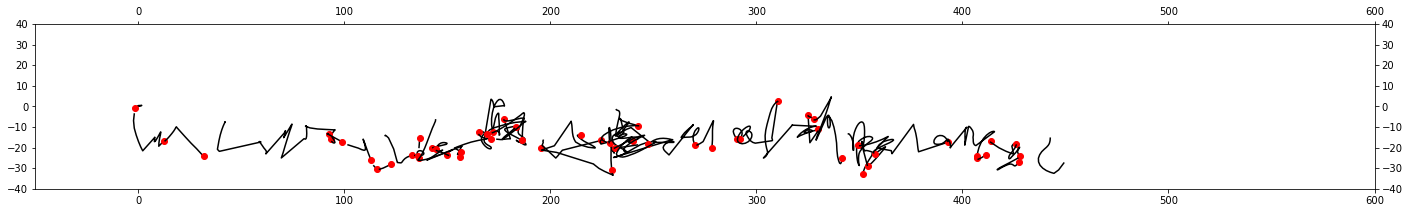

Model name model_with_attention.pt and try number: 2


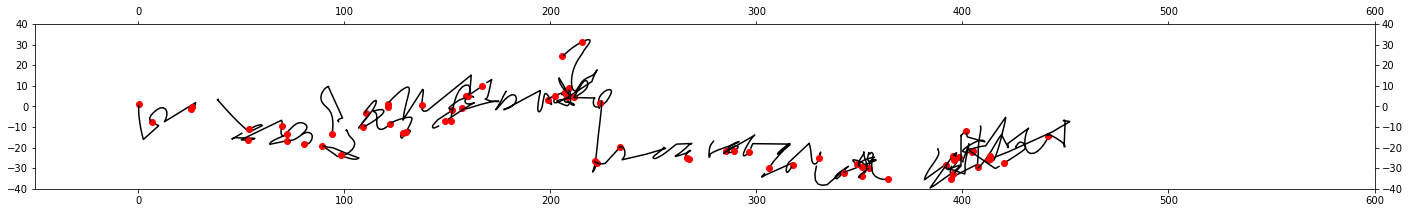

Model name model_with_attention.pt and try number: 3


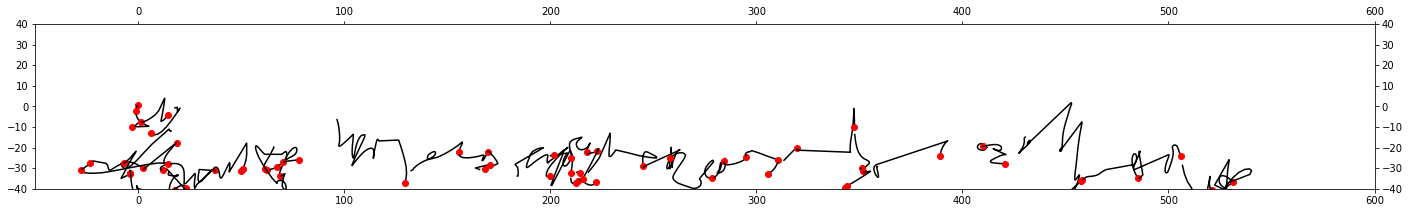

Model name model_with_attention_bs_32.pt and try number: 1


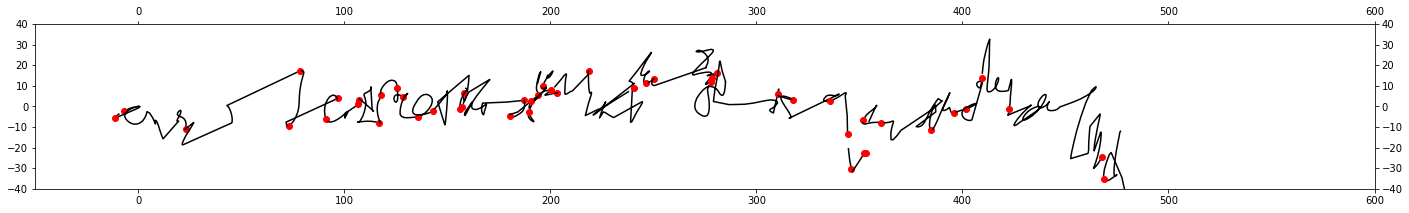

Model name model_with_attention_bs_32.pt and try number: 2


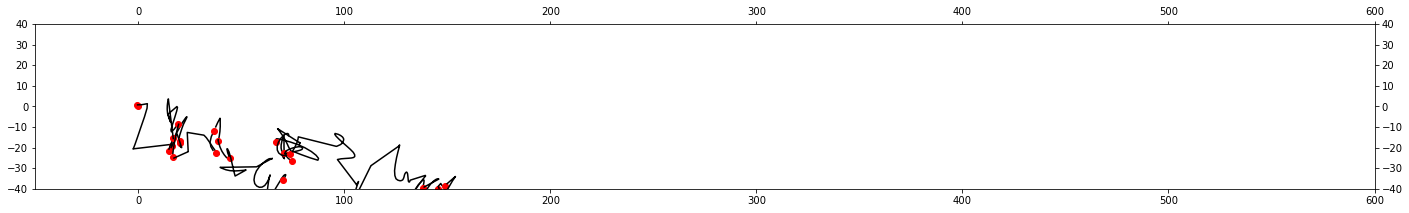

Model name model_with_attention_bs_32.pt and try number: 3


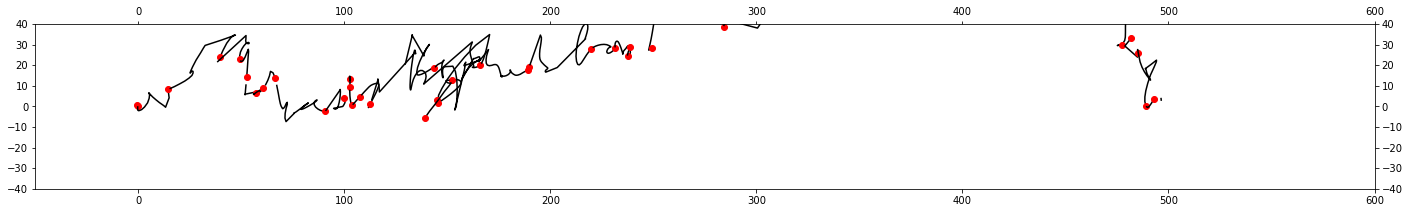

Model name model_with_attention_bs_64.pt and try number: 1


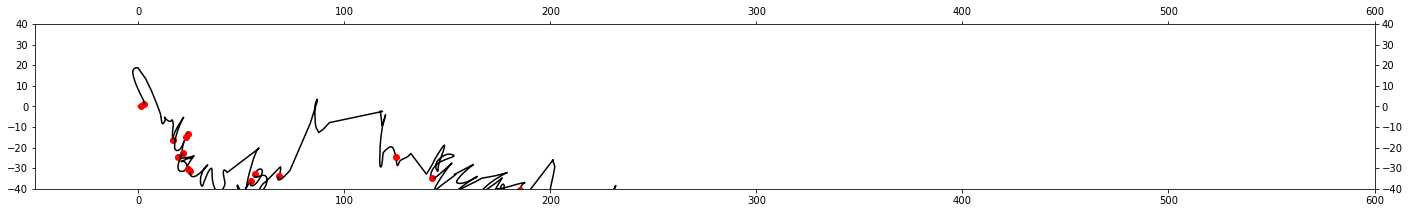

Model name model_with_attention_bs_64.pt and try number: 2


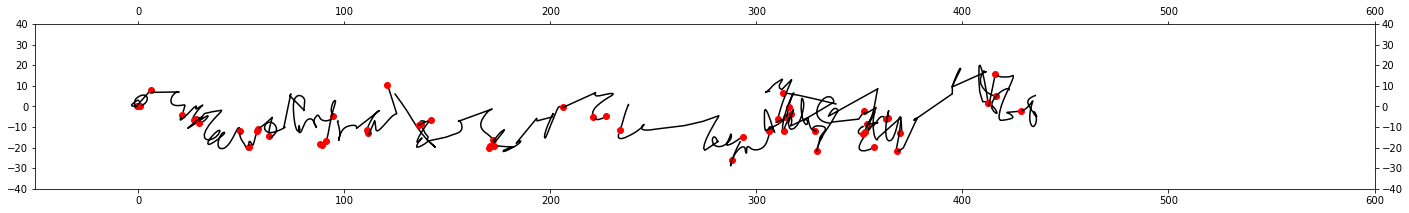

Model name model_with_attention_bs_64.pt and try number: 3


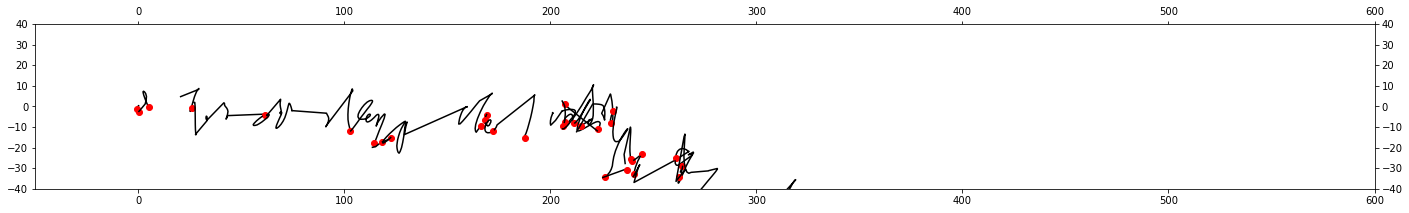

In [10]:
text = "this is a text"
for n,m in models:
    for i in range(3):
        print(f"Model name {n} and try number: {i+1}")
        draw_prediction(text, m)

Model name model_with_attention.pt and try number: 1


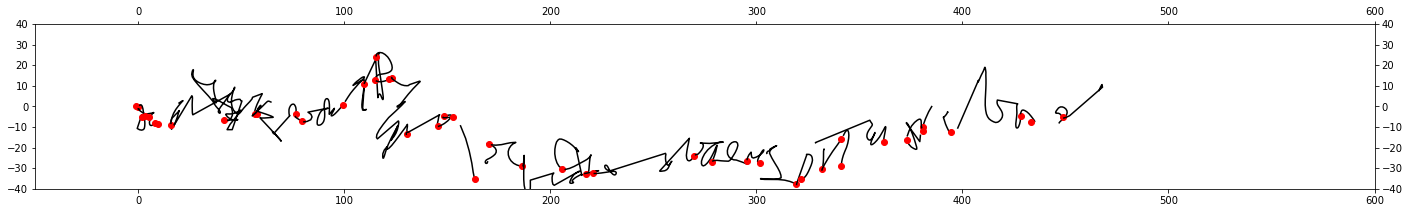

Model name model_with_attention.pt and try number: 2


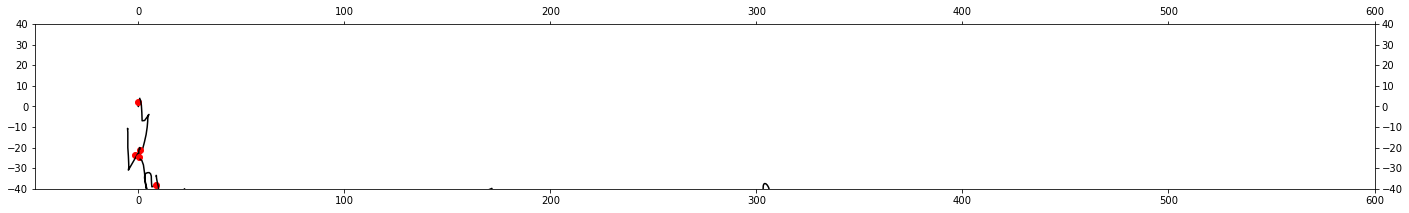

Model name model_with_attention_bs_32.pt and try number: 1


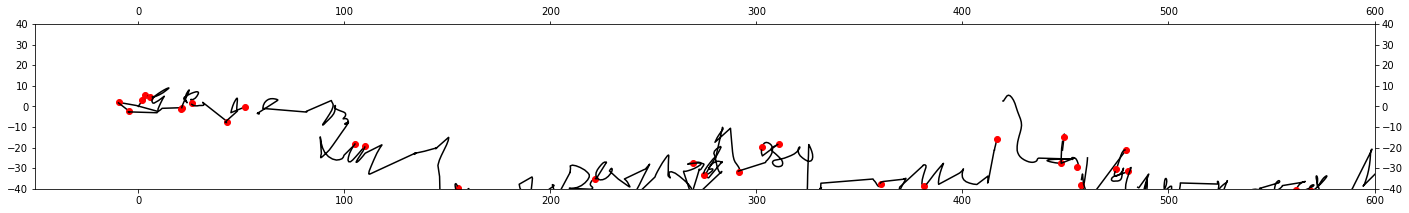

Model name model_with_attention_bs_32.pt and try number: 2


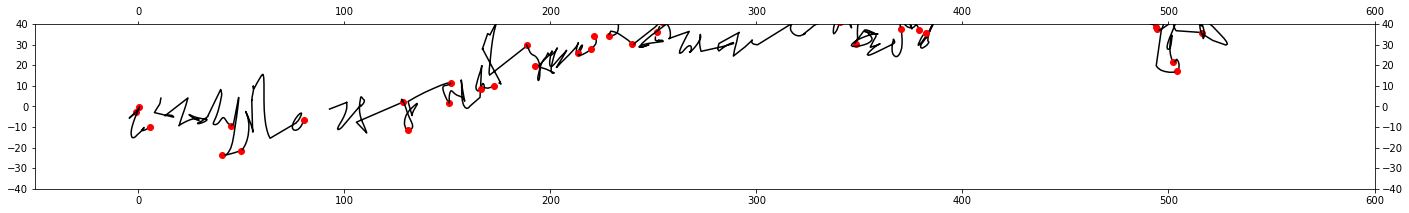

Model name model_with_attention_bs_64.pt and try number: 1


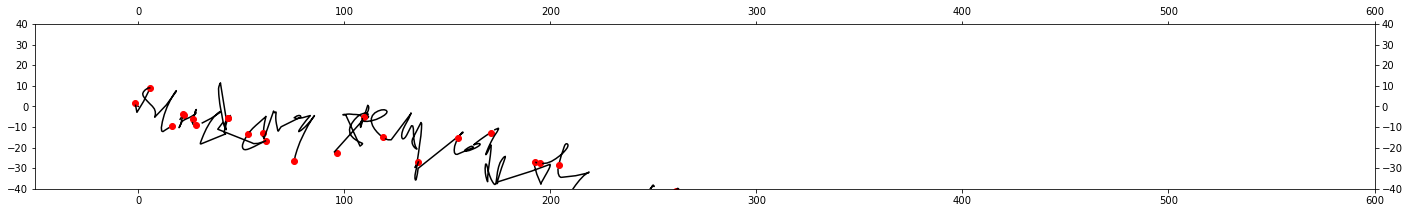

Model name model_with_attention_bs_64.pt and try number: 2


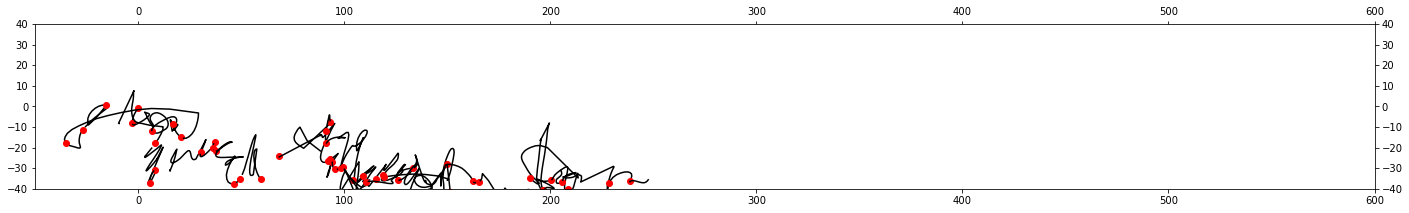

In [11]:
text = "Absolutely this is my theory"
for n,m in models:
    for i in range(2):
        print(f"Model name {n} and try number: {i+1}")
        draw_prediction(text, m)